In [1]:
from pyspark import SparkContext
from pyspark import SparkConf
#Use the alternate least square algorithm and the Rating data structure
from pyspark.mllib.recommendation import ALS, Rating

import os
import sys
from random import randrange
from operator import itemgetter
import timeit
#conf = SparkConf().set("spark.driver.memory", "6g")
#sc = SparkContext.getOrCreate(conf=conf) #new in Spark 2
sc = SparkContext.getOrCreate()

In [2]:
from  pprint import pprint
def title(s):
    pprint("---- %s -----" %s)    
    
def see(s, v):
    pprint("---- %s -----" %s)
    pprint(v)

# Step 1: Reading , Preprocessing 
## 1.1 Reading and caching the files RDDs

In [3]:
base = "./Data/Recommender/"
rawUserArtistData = sc.textFile(base + "user_artist_data.txt").cache()
rawArtistData = sc.textFile(base + "artist_data.txt").cache()
rawArtistAlias = sc.textFile(base + "artist_alias.txt").cache()

In [4]:
see("rawUserArtistData", rawUserArtistData.take(5))
#userId, #artistId, count (rating)

see("rawArtistData", rawArtistData.take(5))
#userId, name

see("rawArtistAlias", rawArtistAlias.take(5))
#artistAlias, artistId

'---- rawUserArtistData -----'
['1000002 1 55',
 '1000002 1000006 33',
 '1000002 1000007 8',
 '1000002 1000009 144',
 '1000002 1000010 314']
'---- rawArtistData -----'
['1134999\t06Crazy Life',
 '6821360\tPang Nakarin',
 '10113088\tTerfel, Bartoli- Mozart: Don',
 '10151459\tThe Flaming Sidebur',
 '6826647\tBodenstandig 3000']
'---- rawArtistAlias -----'
['1092764\t1000311',
 '1095122\t1000557',
 '6708070\t1007267',
 '10088054\t1042317',
 '1195917\t1042317']


# 24296858

## 1.2 Prepare Artist Data
- Convert the artist data into a keypair RDD
- Handle corrupt non-convertable to int ids by ignoring them

In [5]:
'''
    Checks if a string is an integer
'''
def isInt(s):
    try:
        int(s)
        return True
    except ValueError:
        return False

def buildArtistByID(rawArtistData):
    '''
        - convert ther rawArtistData into tuples of (artistID, artistName)
        - filter all bad lines
    '''
    return rawArtistData \
        .map(lambda x: x.split("\t", 1)) \
        .filter(lambda artist: artist[0] and isInt(artist[0])) \
        .map(lambda artist: (int(artist[0]), artist[1].strip()))
        
see("key-pair  ArtistRDD", buildArtistByID(rawArtistData).take(5))

'---- key-pair  ArtistRDD -----'
[(1134999, '06Crazy Life'),
 (6821360, 'Pang Nakarin'),
 (10113088, 'Terfel, Bartoli- Mozart: Don'),
 (10151459, 'The Flaming Sidebur'),
 (6826647, 'Bodenstandig 3000')]


## 1.1 Prepare Artist Aliases
- Intead of joining the rawArtistData with rawArtistAlias, we converert the rawArtistAlias into a python map and we broadcast it.
- Handle corrupt non-convertable to int ids by ignoring them

In [6]:
def buildArtistAlias(rawArtistAlias):
    '''
        - convert ther rawArtistData into tuples of (aliasID, artistID)
        - filter all bad lines
    '''
    return rawArtistAlias \
        .map(lambda line: line.split('\t')) \
        .filter(lambda artist: artist[0] and isInt(artist[0])) \
        .map(lambda artist: (int(artist[0]), int(artist[1]))) \
        .collectAsMap()

#boradcast the artistAlias lookup table instead of doing a join
bArtistAlias = sc.broadcast(buildArtistAlias(rawArtistAlias))

# aliasMap = bArtistAlias.value
# title("Artist Alias as a broadcast map")
# for theAlias, theId in list(aliasMap.items())[:5]:
#     print("%s => %s" % (theAlias,theId))


## 1.2 Prepare Ratings
`Rating(user, product, rating)`
Represents a (user, product, rating) tuple.

```
>>> r = Rating(1, 2, 5.0)
>>> (r.user, r.product, r.rating)
(1, 2, 5.0)
>>> (r[0], r[1], r[2])
(1, 2, 5.0)
```

In [7]:
def getArtistRating(line):
    # Parse the line to extract the 3 fields
    (userID, artistID, count) = map(lambda x: int(x), line.split(' '))
    try:
        # Lookup if the current artistID is an just an alias to an artist
        # The lookup is done from a the broadcast RDD
        finalArtistID = bArtistAlias.value[artistID]
    except KeyError:
        # if the lookup failed, then we have a new artist
        finalArtistID = artistID
    #Finally, create a new rating Object
    return Rating(userID, finalArtistID, count)

# Go over all User-Artist data and convert each line to a Rating object
def buildRatings(rawUserArtistData, bArtistAlias):
    return rawUserArtistData.map(lambda line: getArtistRating(line))

trainData = buildRatings(rawUserArtistData, bArtistAlias).cache()

see("ratings", trainData.take(5))


'---- ratings -----'
[Rating(user=1000002, product=1, rating=55.0),
 Rating(user=1000002, product=1000006, rating=33.0),
 Rating(user=1000002, product=1000007, rating=8.0),
 Rating(user=1000002, product=1000009, rating=144.0),
 Rating(user=1000002, product=1000010, rating=314.0)]


In [8]:
def getArtistRating(line):
    # Parse the line to extract the 3 fields
    (userID, artistID, count) = map(lambda x: int(x), line.split(' '))
    try:
        # Lookup if the current artistID is an just an alias to an artist
        # The lookup is done from a the broadcast RDD
        finalArtistID = bArtistAlias.value[artistID]
    except KeyError:
        # if the lookup failed, then we have a new artist
        finalArtistID = artistID
    #Finally, create a new rating Object
    return (userID, finalArtistID)

# Go over all User-Artist data and convert each line to a Rating object
def buildRatings(rawUserArtistData, bArtistAlias):
    return rawUserArtistData.map(lambda line: getArtistRating(line))

data = buildRatings(rawUserArtistData, bArtistAlias).cache()
data.persist()

PythonRDD[13] at RDD at PythonRDD.scala:48

In [9]:
uCounts = data.countByKey()

In [10]:
uCountList = list(uCounts.items())
#uCountList[:10]
uCountListByArtistCount = map(lambda pair: (pair[1], pair[0]),uCountList)
popularity = sorted(uCountListByArtistCount, reverse=True)[:2000]

col0 = list(map(lambda x:x[0], popularity))
#col0


In [11]:
popularity[:10]

[(6836, 2030067),
 (6188, 1024631),
 (5864, 1059334),
 (5806, 2016026),
 (4863, 2023686),
 (4796, 1045464),
 (4709, 1004584),
 (4512, 2010008),
 (4115, 2232770),
 (4019, 1006093)]

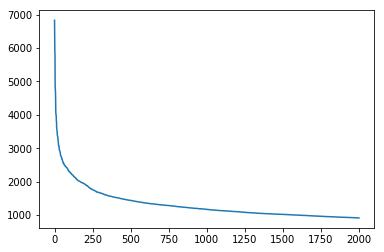

In [12]:
import matplotlib.pyplot as plt
plt.plot(col0)
plt.show()

In [13]:
data.count()

24296858

In [14]:
data.map(lambda x:x[1]).distinct().count()

1568126

In [15]:
data.map(lambda x:x[0]).distinct().count()

148111

# 3 Build the Model

In [16]:
fractionOfRatings = 0.0001
sampleTrainingData = trainData.sample(withReplacement=False, fraction=fractionOfRatings, seed=17)
model = ALS.trainImplicit(ratings=sampleTrainingData, rank=10, iterations=5, lambda_=0.01, alpha=1.0, seed=17)

# 4 Using the Model

## 4.1 See the weights of the k latent features
- use `model.userFeatures`

In [17]:

see("What users like..",model.userFeatures().mapValues(lambda v: ", ".join( map(lambda x: str(x),v) )).take(3))

'---- What users like.. -----'
[(1001552,
  '-4.964401227880444e-07, -2.648578956154779e-08, 2.7233342692056794e-08, '
  '-2.6292698862562247e-07, 1.7509847793917288e-07, 5.979712369708068e-08, '
  '-7.712580440966121e-07, 8.960280695191614e-08, -3.305321172319964e-07, '
  '-3.969996953401278e-07'),
 (1002080,
  '-5.057951626974422e-11, 1.581346512069537e-11, -1.5665697905564713e-11, '
  '-1.2729981131720525e-11, -5.972527333808486e-11, -6.169149219248382e-11, '
  '1.3916656889378931e-11, 5.70713485151253e-12, 4.819996138327731e-11, '
  '-2.971558762943083e-11'),
 (1003072,
  '2.1412743578252957e-08, -1.1094314800175198e-08, 1.669904392542776e-08, '
  '3.790820546356599e-09, 4.077118642697997e-09, -1.242049574301518e-08, '
  '1.2653544878560297e-08, 3.4093201595197797e-09, 1.7116697392793867e-08, '
  '-1.3947881960518771e-08')]


## 4.2 See the top recommendations for a user 
- use `model.recommendProducts`, which gives you the top recommendations

In [18]:
userID = 1003072
recommendations = model.recommendProducts(userID, 20)
see("Recommnded artist ids for user:"+str(userID), recommendations)

'---- Recommnded artist ids for user:1003072 -----'
[Rating(user=1003072, product=1205, rating=9.82389994804957e-09),
 Rating(user=1003072, product=1256375, rating=7.80769372053135e-09),
 Rating(user=1003072, product=1004641, rating=7.72370199864727e-09),
 Rating(user=1003072, product=1000014, rating=7.408890586415736e-09),
 Rating(user=1003072, product=1001277, rating=7.0050826110169915e-09),
 Rating(user=1003072, product=1000591, rating=6.962873645259561e-09),
 Rating(user=1003072, product=1100180, rating=6.787574742556285e-09),
 Rating(user=1003072, product=1019347, rating=6.665325681377832e-09),
 Rating(user=1003072, product=1034635, rating=6.5133778227172464e-09),
 Rating(user=1003072, product=1003950, rating=6.254294185264244e-09),
 Rating(user=1003072, product=1022346, rating=6.059599116669776e-09),
 Rating(user=1003072, product=2041781, rating=6.050427944651426e-09),
 Rating(user=1003072, product=1254198, rating=5.877739711375923e-09),
 Rating(user=1003072, product=1651, rating

## 4.3 Compare Recommendations to Existing genres
- We can not judge easily the quality of the recommendations

In [19]:
artistByID = buildArtistByID(rawArtistData)
userID = 1003072
def getExistingArtistsOfAuser(rawUserArtistData, artistByID, userID):
    #get all the productIds that a particular user is interested in 
    existingProducts = rawUserArtistData\
        .map(lambda x: x.split(' '))\
        .filter(lambda x: int(x[0]) == userID)\
        .map(lambda x: int(x[1])).collect()

    #convert product(artist) id to name    
    existingArtistsRDD = artistByID.filter(lambda artist: artist[0] in existingProducts)
    return existingArtistsRDD
    
see("Existing Artists of user: "+str(userID), getExistingArtistsOfAuser(rawUserArtistData, artistByID, userID).take(10))

def getRecommendedArtistsOfAuser(model,  artistByID, userID):
    recommendations = model.recommendProducts(userID, 10)
    recommendedProductIDs = list(map(lambda rec: rec.product, recommendations))
    #print(list(recommendedProductIDs))
    recommendedArtistsRDD = artistByID.filter(lambda artist: artist[0] in recommendedProductIDs)
    return recommendedArtistsRDD

see("Recommended Artists for user: "+str(userID), getRecommendedArtistsOfAuser(model, artistByID, userID).take(10))

'---- Existing Artists of user: 1003072 -----'
[(1021038, 'Inzite'),
 (1247272, '植松伸夫'),
 (1839, 'Alabama 3'),
 (1027406, 'Twenty Something'),
 (1251595, 'Tankis & Savietto'),
 (1019003, 'Giuseppe di Lucci'),
 (3437, 'Enigma'),
 (407, 'Eurythmics'),
 (1005901, 'Zymotix'),
 (2138, 'Lifehouse')]
'---- Recommended Artists for user: 1003072 -----'
[(1003950, 'Dark Tranquillity'),
 (1000014, 'Pantera'),
 (1034635, '[unknown]'),
 (1000591, 'The Chemical Brothers'),
 (1256375, '浜崎あゆみ'),
 (1205, 'U2'),
 (1019347, 'Armor for Sleep'),
 (1100180, 'Kite Flying Society'),
 (1001277, '311'),
 (1004641, 'Slowdive')]


# Quality

In [20]:
# sampleCrossValidationData = trainData #sample(withReplacement=False, fraction=0.999, seed=17)
# sampleCrossValidationData.filter(lambda v: v[0]==1003072).take(5)


In [21]:
# qualityRdd = sampleTrainingData.map(lambda v: v[0]).sample(withReplacement=False, fraction=0.01, seed=17)
# qualityRdd = data.map(lambda v: v[0]).sample(withReplacement=False, fraction=0.000001, seed=17)
# qualityRdd.take(1)
quality = data.map(lambda v: v[0]).sample(withReplacement=False, fraction=0.000001, seed=17).collect()
len(quality)
quality

[1059334,
 1072209,
 2018101,
 2024572,
 2072455,
 2110492,
 2145524,
 2146748,
 2156465,
 2204277,
 2247374,
 2262837,
 2263817,
 2291265,
 2294499,
 2310408,
 2323607,
 2339372,
 2373595,
 2377209,
 2395212,
 2398785,
 2417274]

In [22]:
trainData.take(12)

[Rating(user=1000002, product=1, rating=55.0),
 Rating(user=1000002, product=1000006, rating=33.0),
 Rating(user=1000002, product=1000007, rating=8.0),
 Rating(user=1000002, product=1000009, rating=144.0),
 Rating(user=1000002, product=1000010, rating=314.0),
 Rating(user=1000002, product=1000013, rating=8.0),
 Rating(user=1000002, product=1000014, rating=42.0),
 Rating(user=1000002, product=1000017, rating=69.0),
 Rating(user=1000002, product=1000024, rating=329.0),
 Rating(user=1000002, product=1000025, rating=1.0),
 Rating(user=1000002, product=1000028, rating=17.0),
 Rating(user=1000002, product=1000031, rating=47.0)]

In [23]:
# innerLoop = 100
# # tPos = sc.parallelize(trainData.filter(lambda v: v[0]==1059334).map(lambda v: (v[1],v[2])).take(innerLoop)).collectAsMap()
# tPos = sc.parallelize(trainData.filter(lambda v: v[0]==quality[0]).map(lambda v: (v[2])).take(innerLoop)).collect()
# # tNeg = sc.parallelize(model.recommendProducts(1059334, innerLoop)).map(lambda v: (v[1],v[2])).collectAsMap()
# tNeg = sc.parallelize(model.recommendProducts(1059334, innerLoop)).map(lambda v: (v[2])).collect()

In [24]:
#tPos

In [25]:
#tNeg

In [38]:
start_time = timeit.default_timer()
#quality = [1059334, 2146748]
grandLoop = len(quality)
innerLoop = 100
runs = 0
avgQuality1 = 0

for userRandom in range(0,len(quality)):
    tPos1 = trainData.filter(lambda v: v[0]==quality[userRandom]).map(lambda v: (v[2])).take(innerLoop)
    tNeg1 = sc.parallelize(model.recommendProducts(quality[userRandom], innerLoop)).map(lambda v: (v[2])).collect()
    count = 0

    for i in range(0,len(tPos1)):
        for j in range(0, len(tNeg1)):
            if tPos1[i]>tNeg1[j]:
                count = count +1
            else:
                pass
    runs = runs + 1
    avgQuality1 = (avgQuality1+count)
elapsed1 = timeit.default_timer() - start_time

In [39]:
elapsed1

107.64477006969355

In [28]:
print("Quality1 measured: %"+str((avgQuality1/(len(tPos1)*len(tNeg1)*grandLoop))*100))

Quality1 measured: %96.65217391304348


# methode 2 - Trying to enhance the running time/performance

In [36]:
start_time = timeit.default_timer()
#quality = [1059334, 2146748]
grandLoop = len(quality)
innerLoop = 100
avgQuality2 = 0

def reco (tPos2, user):
    count = 0
    tNeg2 = model.recommendProducts(user, innerLoop)
    for j in range(0,len(tPos2)):
        for i in range(0,len(tNeg2)):
            if tPos2[j] > tNeg2[i][2]:
                count = count +1
            else:
                pass
    return count


for userRandom in range(0,len(quality)):
    tPos2 = trainData.filter(lambda v: v[0]==quality[userRandom]).map(lambda v: (v[2])).take(innerLoop)
#     avgQualityArray = map(reco, tPos)
    avgQuality2 = avgQuality2 + reco(tPos2, quality[userRandom])
elapsed2 = timeit.default_timer() - start_time

In [37]:
elapsed2

96.71878072426625

In [31]:
print("Quality2 measured: %"+str((avgQuality2/(len(tPos2)*innerLoop*grandLoop))*100))

Quality2 measured: %96.65217391304348
